<a href="https://colab.research.google.com/github/SaraBabakN/Model-Search/blob/master/new_maxpool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, I have put a max-pooling and an unpooling layer at the end of each layer. 


** The only problem is that in the unpooling layer. What we wanted was replacing all the values of each pool with its maximum. But, here, I replaced the nun-max elements with zero and saved the maximum. This will reduce our data but, I could not find a way to do what exactly we wanted.  


I have repeated tests for this new network, and It has reached similar accuracy.

Overall, I could not see any new information from this test due to similar trends and results. The only point is that we have transferred fewer data to the next layer with similar accuracy. 

In [1]:
from datetime import datetime
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

train_set = torchvision.datasets.CIFAR10('./dataset', train=True, download=True,
                                         transform=transforms.Compose([transforms.ToTensor()]))


def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

0it [00:00, ?it/s]

170500096it [00:04, 40922497.33it/s]                               


Extracting ./dataset/cifar-10-python.tar.gz to ./dataset


In [0]:
lr = 0.01
batch_size = 200
dataset_size = 50000
epoch_num = 40
epsilon = 0.000001
threshold = 0.001 

In [0]:
def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

In [0]:
class BasicBlock(nn.Module): 
    expansion = 1 
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out   

In [0]:
class myModel(nn.Module):

    def __init__(self, block,groups=1, width_per_group=64):
        super(myModel, self).__init__()
        norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        self.inplanes = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = norm_layer(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.newMax =  nn.MaxPool2d(2, stride=2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2, stride=2)
        self.layer1 = self._make_layer(block, 64)
        self.layer2 = self._make_layer(block, 64)
        self.layer3 = self._make_layer(block, 128, stride=2)
        self.layer4 = self._make_layer(block, 128,)
        self.layer5 = self._make_layer(block, 256, stride=2)
        self.layer6 = self._make_layer(block, 256)
        self.layer7 = self._make_layer(block, 512, stride=2)
        self.layer8 = self._make_layer(block, 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , 10)

    def _make_layer(self, block, planes, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes
        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)

        x , indices = self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer2(x)

        x , indices= self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer3(x)

        x , indices= self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer4(x)

        x, indices = self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer5(x)

        x, indices = self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer6(x)

        x , indices= self.newMax(x)
        x = self.unpool(x, indices)

        x = self.layer7(x)
        x = self.layer8(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)

In [0]:
def myResnet(pretrained=False, progress=True, **kwargs):
    return myModel(BasicBlock,**kwargs)

In [0]:
myNet = myResnet().cuda()
data_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
optimizer = optim.Adam(myNet.parameters(), lr=lr)

In [8]:
for epoch in range(epoch_num):
    correct = 0 
    for batch in data_loader:
        images, labels = batch
        images = images.cuda() 
        labels = labels.cuda()
        preds = myNet(images)
          
        loss = nn.functional.cross_entropy(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct = correct + get_num_correct(preds,labels)
    print("epoch", epoch, "accuracy" , correct)

epoch 0 accuracy 16103
epoch 1 accuracy 24852
epoch 2 accuracy 28813
epoch 3 accuracy 31854
epoch 4 accuracy 34335
epoch 5 accuracy 36312
epoch 6 accuracy 37827
epoch 7 accuracy 39098
epoch 8 accuracy 40327
epoch 9 accuracy 41605
epoch 10 accuracy 42454
epoch 11 accuracy 43367
epoch 12 accuracy 44100
epoch 13 accuracy 45101
epoch 14 accuracy 45502
epoch 15 accuracy 46099
epoch 16 accuracy 46653
epoch 17 accuracy 47008
epoch 18 accuracy 47398
epoch 19 accuracy 47656
epoch 20 accuracy 47865
epoch 21 accuracy 48048
epoch 22 accuracy 48034
epoch 23 accuracy 48143
epoch 24 accuracy 48353
epoch 25 accuracy 48463
epoch 26 accuracy 48546
epoch 27 accuracy 48555
epoch 28 accuracy 48792
epoch 29 accuracy 48645
epoch 30 accuracy 48687
epoch 31 accuracy 48827
epoch 32 accuracy 48860
epoch 33 accuracy 48683
epoch 34 accuracy 48941
epoch 35 accuracy 48950
epoch 36 accuracy 49066
epoch 37 accuracy 48931
epoch 38 accuracy 49017
epoch 39 accuracy 49055


In [49]:
49055/50000

0.9811

In [0]:
x = myNet.conv1(images)
x = myNet.bn1(x)
x = myNet.relu(x)
x = myNet.maxpool(x)
x = myNet.layer1(x)
x = myNet.layer2(x)
x , indices= myNet.newMax(x)
x = myNet.unpool(x, indices)

l3 = myNet.layer3(x)

modulList = list(myNet.layer3.modules())

x1 = modulList[2](x)
x1 = modulList[3](x1)
x1 = modulList[4](x1)
x1 = modulList[5](x1)
x1 = modulList[6](x1)

x2 = modulList[7](x)


Text(0.5, 1.0, 'output pf each layer after relu')

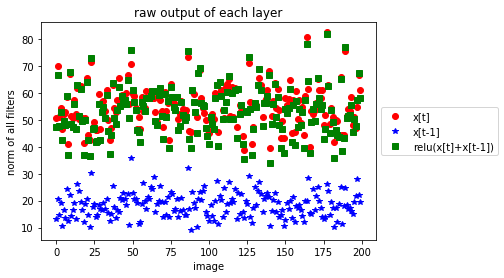

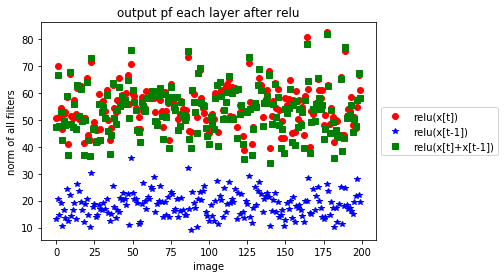

In [15]:
# Whole layer 
a = torch.norm(x1.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(x2.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm((l3).reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("image")
plt.ylabel("norm of all filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("raw output of each layer")

x3 = nn.ReLU(inplace=True)(x1)
x4 = nn.ReLU(inplace=True)(x2)
a = torch.norm(x3.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(x4.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("image")
plt.ylabel("norm of all filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("output pf each layer after relu")


# plt.savefig('/content/drive/My Drive/data1/layer3')

In [16]:
a = torch.norm(x1.clone().detach().cpu(),dim=(2,3))
b = torch.norm(x2.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a + epsilon) 
print (torch.nonzero(c < treshold).shape)
c = torch.div(a , b + epsilon) 
print (torch.nonzero(c < treshold).shape)


torch.Size([3353, 2])
torch.Size([171, 2])


In [52]:
a = torch.norm(x1.clone().detach().cpu(),dim=(2,3))
b = torch.norm(x2.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a + epsilon) 
d = torch.div(a , b + epsilon) 
indic_c = (torch.nonzero( c[0] < threshold)).reshape(-1)
indic_d = (torch.nonzero( d[0] < threshold)).reshape(-1)
for i in range(200): 
  indic_c = (torch.nonzero( c[i][indic_c] < threshold)).reshape(-1)
  indic_d = (torch.nonzero( d[i][indic_d] < threshold)).reshape(-1)
print(indic_c.numel()) #number of elements 
print(indic_d.numel())


0
0


Text(0.5, 1.0, 'layer 2 - random image1 - output pf each layer after relu')

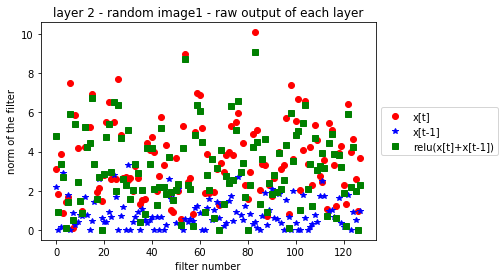

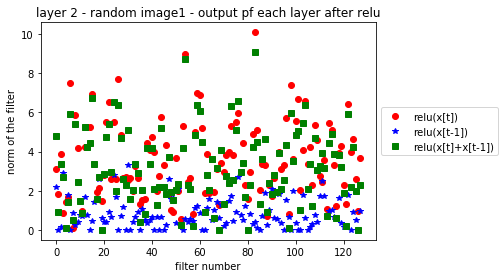

In [17]:
# Singel image, different filters 
imageNumber = 100 
# Whole layer 
a = torch.norm(x1[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x2[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l3[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (128)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 2 - random image1 - raw output of each layer" 
plt.title(name)

a = torch.norm(x3[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x4[imageNumber].clone().detach().cpu(),dim=(1,2))
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 2 - random image1 - output pf each layer after relu" 
plt.title(name)

In [0]:
x , indices= myNet.newMax(l3)
l3 = myNet.unpool(x, indices)
l4 = myNet.layer4(l3)
x , indices= myNet.newMax(l4)
l4 = myNet.unpool(x, indices)
l5 = myNet.layer5(l4)

modulList = list(myNet.layer5.modules())

x5 = modulList[2](l4)
x5 = modulList[3](x5)
x5 = modulList[4](x5)
x5 = modulList[5](x5)
x5 = modulList[6](x5)

x6 = modulList[7](l4)

Text(0.5, 1.0, 'output pf each layer after relu')

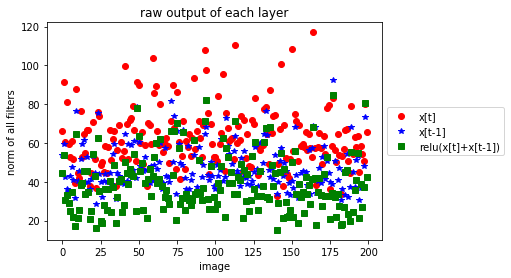

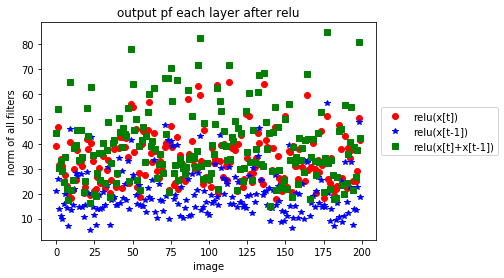

In [26]:
#Whole layer 
a = torch.norm(x5.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(x6.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm((l5).reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("image")
plt.ylabel("norm of all filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("raw output of each layer")
# plt.savefig('/content/drive/My Drive/data1/layer3')

x7 = nn.ReLU(inplace=True)(x5)
x8 = nn.ReLU(inplace=True)(x6)
a = torch.norm(x7.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(x8.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("image")
plt.ylabel("norm of all filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("output pf each layer after relu")

Text(0.5, 1.0, 'layer 3 - random image1 - output pf each layer after relu')

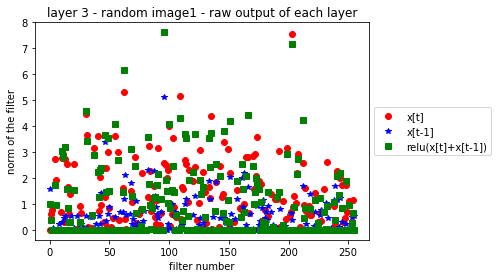

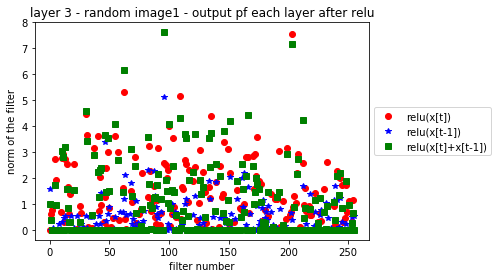

In [27]:
# Singel image, different filters 
imageNumber = 100 
a = torch.norm(x5[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x6[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l5[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (256)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
name = "layer 3 - random image1 - raw output of each layer" 
plt.title(name)

a = torch.norm(x7[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x8[imageNumber].clone().detach().cpu(),dim=(1,2))
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - random image1 - output pf each layer after relu" 
plt.title(name)

Text(0.5, 1.0, 'layer 3 - random image2 - output pf each layer after relu')

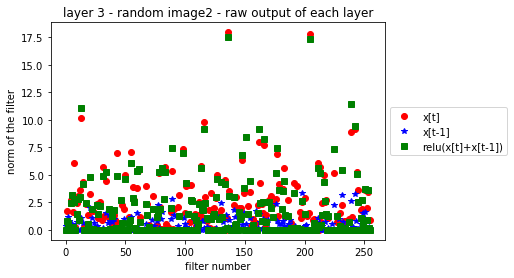

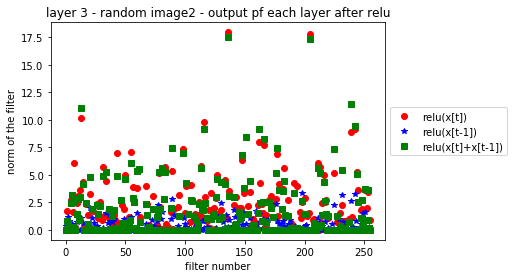

In [28]:
# Singel image, different filters 
imageNumber = 150 
a = torch.norm(x5[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x6[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l5[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (256)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - random image2 - raw output of each layer" 
plt.title(name)

a = torch.norm(x7[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x8[imageNumber].clone().detach().cpu(),dim=(1,2))
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 3 - random image2 - output pf each layer after relu" 
plt.title(name)

In [0]:
a = torch.norm(x5.clone().detach().cpu(),dim=(2,3))
b = torch.norm(x6.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a + epsilon) 
print (torch.nonzero(c < treshold).shape)
d = torch.div(a , b + epsilon) 
print (torch.nonzero(c < treshold).shape)

indic_c = (torch.nonzero( c[0] < threshold)).reshape(-1)
print(indic_c.shape)
indic_d = (torch.nonzero( d[0] < threshold)).reshape(-1)
for i in range(200): 
  indic_c = (torch.nonzero( c[i][indic_c] < threshold)).reshape(-1)
  print(indic_c.shape)
  indic_d = (torch.nonzero( d[i][indic_d] < threshold)).reshape(-1)
print(indic_c)
print(indic_d)

In [0]:
x , indices= myNet.newMax(l5)
l5 = myNet.unpool(x, indices)
l6= myNet.layer6(l5)
x , indices= myNet.newMax(l6)
l6 = myNet.unpool(x, indices)
modulList = list(myNet.layer7.modules())

l7 = myNet.layer7(l6) 

x9 = modulList[2](l6)
x9 = modulList[3](x9)
x9 = modulList[4](x9)
x9 = modulList[5](x9)
x9 = modulList[6](x9)

x10 = modulList[7](l6)

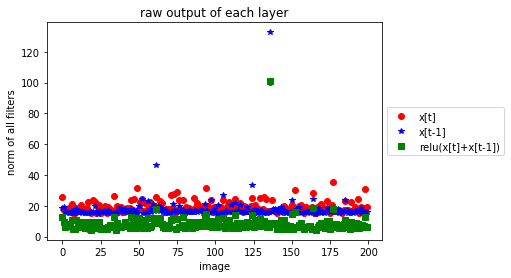

<Figure size 432x288 with 0 Axes>

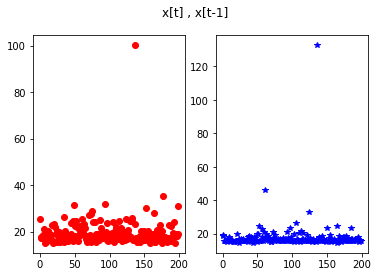

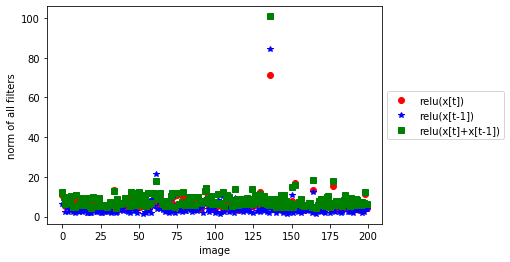

In [45]:
#Whole layer 
a = torch.norm(x9.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(x10.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
c = torch.norm((l7).reshape(batch_size,-1).clone().detach().cpu(),dim=1)
t= range (batch_size)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("image")
plt.ylabel("norm of all filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("raw output of each layer")

plt.figure(2)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('x[t] , x[t-1]')
ax1.plot(t, a[t], 'ro')
ax2.plot(t, b[t] , 'b*')

x11 = nn.ReLU(inplace=True)(x9)
x12 = nn.ReLU(inplace=True)(x10)
a = torch.norm(x11.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
b = torch.norm(x12.reshape(batch_size,-1).clone().detach().cpu(),dim=1)
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("image")
plt.ylabel("norm of all filters")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

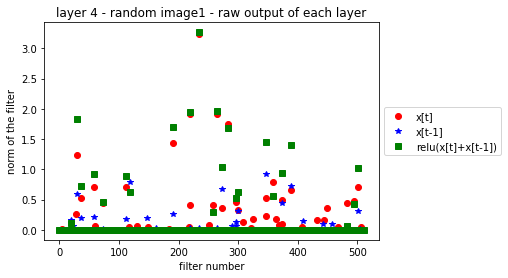

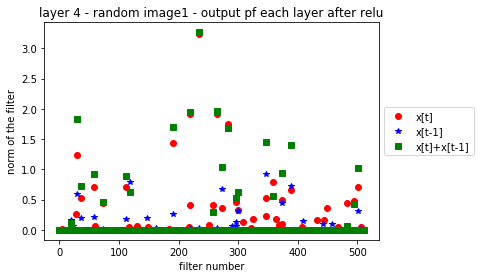

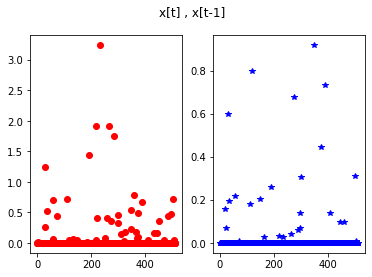

In [46]:
# Singel image, different filters 
imageNumber = 100
a = torch.norm(x9[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x10[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l7[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (512)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - random image1 - raw output of each layer" 
plt.title(name)

a = torch.norm(x11[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x12[imageNumber].clone().detach().cpu(),dim=(1,2))
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "x[t]+x[t-1]")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - random image1 - output pf each layer after relu" 
plt.title(name)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('x[t] , x[t-1]')
ax1.plot(t, a[t], 'ro')
ax2.plot(t, b[t] , 'b*')

Text(0.5, 1.0, 'layer 4 - random image2 - output pf each layer after relu')

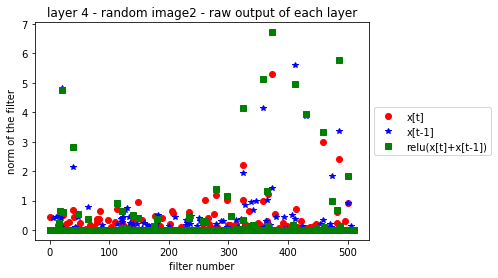

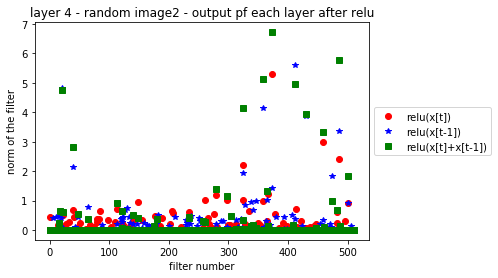

In [47]:
# Singel image, different filters 
imageNumber = 150 
a = torch.norm(x9[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x10[imageNumber].clone().detach().cpu(),dim=(1,2))
c = torch.norm(l7[imageNumber].clone().detach().cpu(),dim=(1,2))
t= range (512)
plt.figure(0)
plt.plot(t,a[t] , 'ro' , label = "x[t]" )
plt.plot(t,b[t] , 'b*' , label = "x[t-1]")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - random image2 - raw output of each layer" 
plt.title(name)

a = torch.norm(x11[imageNumber].clone().detach().cpu(),dim=(1,2))
b = torch.norm(x12[imageNumber].clone().detach().cpu(),dim=(1,2))
plt.figure(1)
plt.plot(t,a[t] , 'ro' , label = "relu(x[t])" )
plt.plot(t,b[t] , 'b*' , label = "relu(x[t-1])")
plt.plot(t,c[t] , 'gs' , label = "relu(x[t]+x[t-1])")
plt.xlabel("filter number")
plt.ylabel("norm of the filter")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
name = "layer 4 - random image2 - output pf each layer after relu" 
plt.title(name)

In [0]:
a = torch.norm(x9.clone().detach().cpu(),dim=(2,3))
b = torch.norm(x10.clone().detach().cpu(),dim=(2,3))
c = torch.div(b , a + epsilon) 
print (torch.nonzero(c < treshold).shape)
d = torch.div(a , b + epsilon) 
print (torch.nonzero(c < treshold).shape)

indic_c = (torch.nonzero( c[0] < threshold)).reshape(-1)
print(indic_c.shape)
indic_d = (torch.nonzero( d[0] < threshold)).reshape(-1)
for i in range(200): 
  indic_c = (torch.nonzero( c[i][indic_c] < threshold)).reshape(-1)
  indic_d = (torch.nonzero( d[i][indic_d] < threshold)).reshape(-1)
print(indic_c)
print(indic_d)